In [1]:
import numpy as np
from scipy.stats import sem

# import my functions
# import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.stats import sem
from scipy.interpolate import interp1d


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import natural images

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [3]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = np.mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Signal

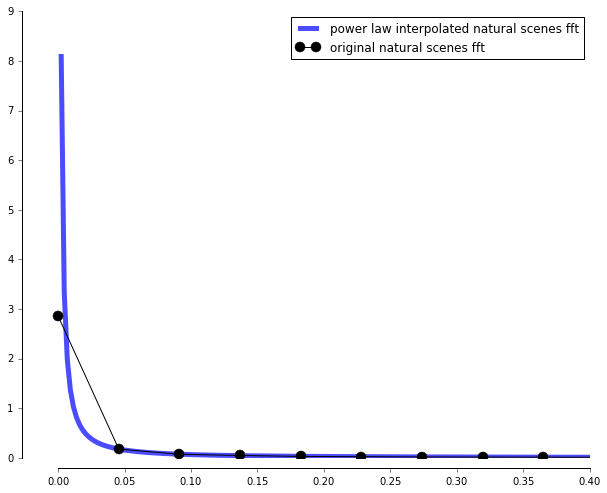

In [73]:
# interpolate signal amplitude
# power law
npoints = 10000
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
more_signal_freq   = np.linspace(0., originalFreqs[-1], npoints)[1:]
more_signal_amp = func(more_signal_freq, *popt)

plt.plot(more_signal_freq, more_signal_amp, 'b', linewidth=5, alpha=0.7, label='power law interpolated natural scenes fft')
plt.plot(originalFreqs, originalSpectra, 'k.-', markersize=20, label='original natural scenes fft')
plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## Define information at a given frequency

In [76]:
def info_at_freq(freqs, signal_amplitude, filter_interpolation_function, function_const=1., input_noise=0.12, output_noise=0.35):
    numerator = (signal_amplitude * function_const * filter_interpolation_function(freqs))**2
    denominator = ((input_noise * function_const * filter_interpolation_function(freqs))**2 + output_noise**2)
    return 0.5*np.log2(1 + (numerator/denominator))

# Get center width from ganglion cell data

In [77]:
ganglion_rfs = load_ganglion_cells()
interp_ganglions     = get_interp(ganglion_rfs, nPoints = 500, mode='valid')
aligned_ganglion_rfs = np.vstack([y for x,y in interp_ganglions])
valid_space          = interp_ganglions[0][0] - 0.25
mean_ganglion = np.mean(aligned_ganglion_rfs, axis=0)

In [78]:
def diff_of_gaussians(space, center_width, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=center_width, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [79]:
def diff_of_gaussians_fixed_center(space, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=1.751050, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [80]:
popt, pcov = curve_fit(diff_of_gaussians, valid_space, mean_ganglion, p0=[1.7, 7.4, -11, -60])
popt

array([  1.47729653,   8.46181925,  -6.11208239, -25.92723796])

In [81]:
difference = diff_of_gaussians(valid_space, *popt)

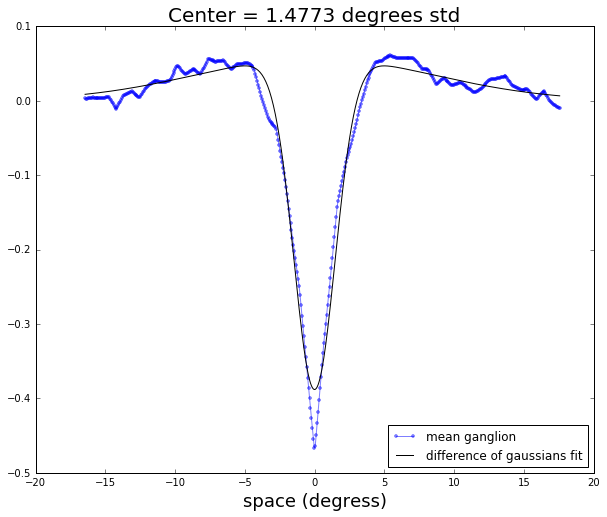

In [82]:
plot(valid_space, mean_ganglion, 'b.-', alpha=0.5, label='mean ganglion')
plot(valid_space, difference, 'k', label='difference of gaussians fit')
plt.legend(loc='lower right')
plt.xlabel('space (degress)', fontsize=18)
plt.title('Center = %0.4f degrees std' %(popt[0]), fontsize=20)

# Define model

In [83]:
def filter_model(horz_weight, ama_weight, center_weight, surround_weight, center_width=1.751050):
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround

    # Amplitude Spectrum of RF
    rf_f_two_sided = abs(np.fft.fft(rf)) / np.prod(rf.shape)
    n = len(rf_f_two_sided)
    if n % 2 == 0:
        rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
    else:
        rf_f_one_sided = rf_f_two_sided[:(n-1)/2 + 1]
    rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

    rf_interp = interp1d(rf_freqs_one_sided, rf_f_one_sided, kind='slinear', fill_value=[0.0], bounds_error=False)
    
    return rf_interp

## Find ideal filter that maximizes information

In [84]:
input_noise = 0.12
output_noise = 0.35

The relative error from this choice of Lagrangian multiplier is 3.44885071653e-07.


/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:111: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_ffts.append(two_sided[:n/2 + 1])


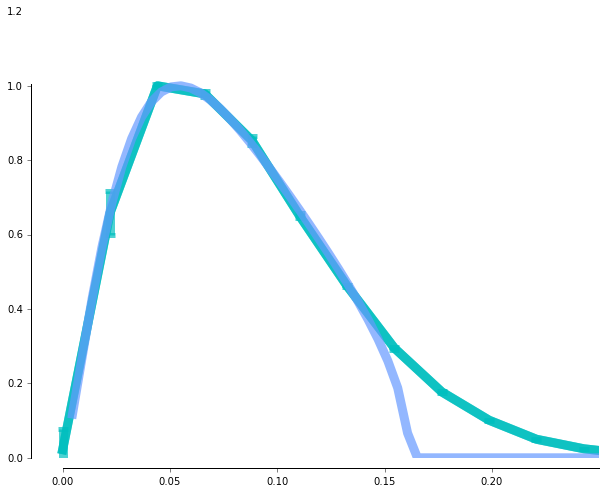

In [85]:
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=input_noise, outputNoise=output_noise,
                                                                     center_weighting=7.7844, surround_weighting=.5085,
                                                                     horz_weighting=.223, ama_weighting=1.165,
                                                                     center_width=1.86945,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                                       statistics=True)

#### And make an interpolation of it

In [92]:
ideal_filter_interp = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal), kind='linear', 
                               bounds_error=False, fill_value='extrapolate')
output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(output_variance)

1227.34527288


(0, 0.3)

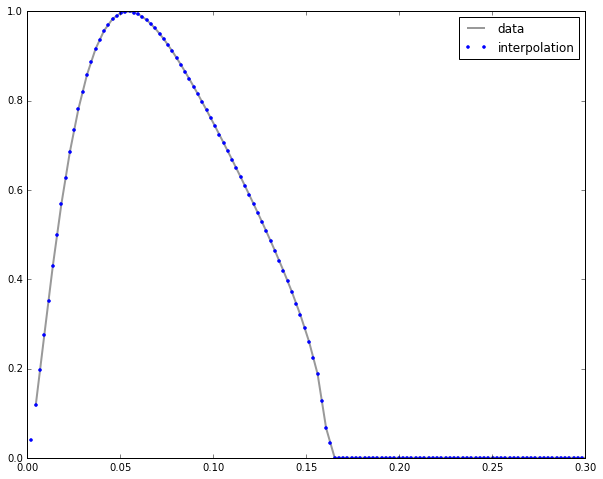

In [97]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), 'k', linewidth=2, alpha=0.4, label='data')
plt.plot(more_signal_freq, ideal_filter_interp(more_signal_freq), 'b.', label='interpolation')
plt.legend()
plt.xlim([0,0.3])

# Now fit the models (full, horizontal only, amacrine only) to ideal filter

In [101]:
popt[0]

1.4772965311658066

In [102]:
cutoff = 0.4
center_width = popt[0]

### Full model

In [103]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
model_freqs, model_fft, horz_weight, ama_weight, center_weight, surround_weight, center_width = fit_ideal(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs),
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
model_interp, model_popt = fit_ideal(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(model_popt)
print('Horizontal weight is %f, Amacrine weight is %f' %(horz_weight, ama_weight))
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:642: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:642: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]


[ 2.07849195 -0.66782325  5.27157877  0.24378478]
Horizontal weight is 0.976819, Amacrine weight is -0.313854
Center weight is 5.253973, Surround weight is 0.502859
Center is 1.477297 std wide


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:642: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]


(0, 0.4)

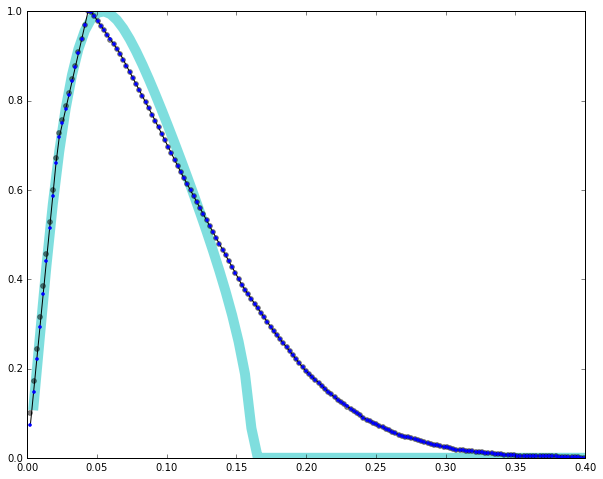

In [106]:
model_filter_interp = filter_model(*model_popt, center_width=center_width)
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='c', linewidth=10, alpha=0.5)
plt.plot(model_freqs, model_fft, 'k.', linewidth=2, markersize=10, alpha=0.5)
plt.plot(lowerer_freqs, model_filter_interp(lowerer_freqs)/np.nanmax(model_filter_interp(lowerer_freqs)), 'k')
plt.plot(model_freqs, model_interp(model_freqs, *model_popt), 'b.')
plt.xlim([0,.4])

### Horizontal model

In [107]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
h_freqs, h_fft, center_weight, surround_weight, center_width = fit_ideal_horz_only(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs), 
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
h_interp, h_popt = fit_ideal_horz_only(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(h_popt)
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:706: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:706: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]


[ 1.18588179  0.08852288]
Center weight is 1.185882, Surround weight is 0.088523
Center is 1.477297 std wide


In [108]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
a_freqs, a_fft, center_weight, surround_weight, center_width = fit_ideal_ama_only(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs), 
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
a_interp, a_popt = fit_ideal_ama_only(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(a_popt)
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

[ 6307.60318364   689.83300824]
Center weight is 6497.543937, Surround weight is 710.604971
Center is 1.477297 std wide


/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:770: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:770: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]


(0, 1.1)

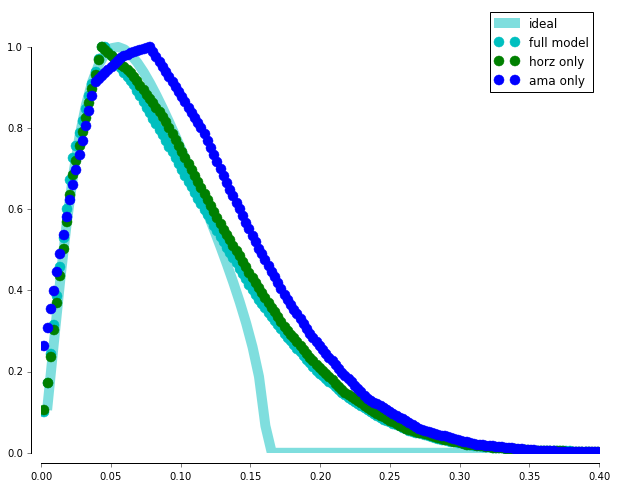

In [109]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='c', linewidth=10, alpha=0.5, label='ideal')
plt.plot(model_freqs, model_fft, 'c.', linewidth=2, markersize=20, label='full model')
plt.plot(h_freqs, h_fft, 'g.', linewidth=2, markersize=20, label='horz only')
plt.plot(a_freqs, a_fft, 'b.', linewidth=2, markersize=20, label='ama only')
plt.xlim([0,.4])
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.ylim([0,1.1])

/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:111: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_ffts.append(two_sided[:n/2 + 1])


The relative error from this choice of Lagrangian multiplier is 7.43094672036e-08.


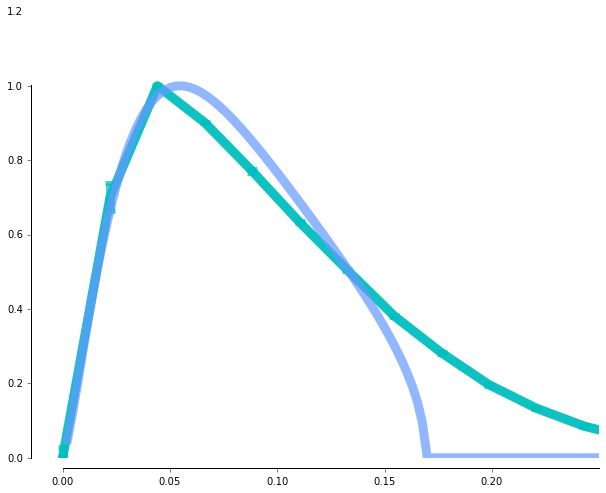

In [110]:
horz_weight, ama_weight, center_weight, surround_weight = model_popt
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=center_weight, surround_weighting=surround_weight,
                                                                     horz_weighting=horz_weight, ama_weighting=ama_weight,
                                                                     center_width=center_width,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=10000, plotFlag='aggregate',
                                                                                       statistics=True)

/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:111: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_ffts.append(two_sided[:n/2 + 1])


The relative error from this choice of Lagrangian multiplier is 1.36924290228e-07.


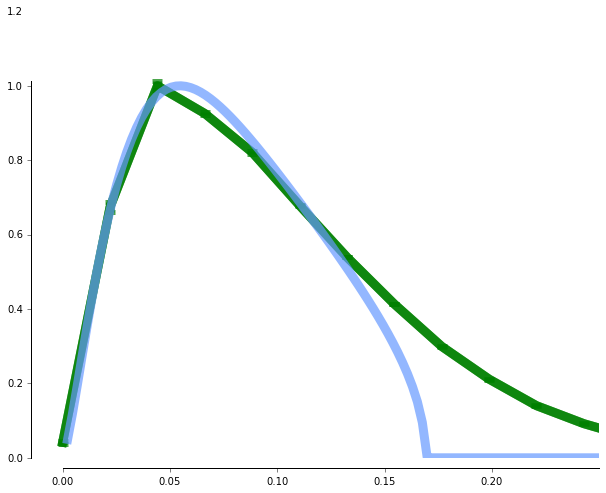

In [111]:
horz_weight = 1.0
ama_weight = 0.0
center_weight, surround_weight = h_popt
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h, h_freqs, h_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=center_weight, surround_weighting=surround_weight,
                                                                     horz_weighting=1.0, ama_weighting=0.0,
                                                                     center_width=center_width,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=10000, plotFlag='aggregate',
                                                                     aggregateColor='g', statistics=True)

/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:111: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
/Users/lmcintosh/code/surround-size/atick_redlich_functions.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  rf_ffts.append(two_sided[:n/2 + 1])


The relative error from this choice of Lagrangian multiplier is 8.17265505878e-08.


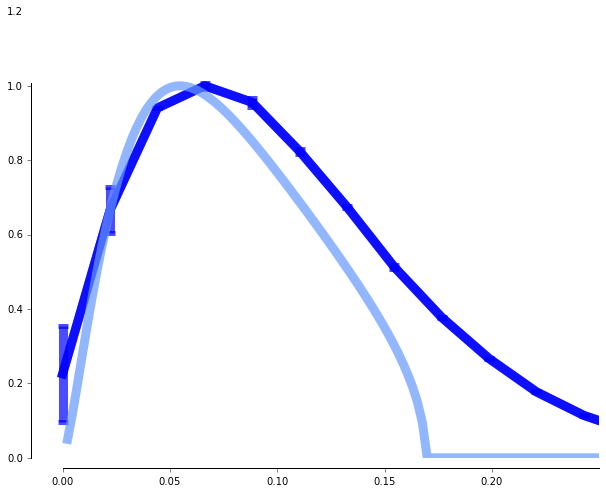

In [112]:
horz_weight = 0.0
ama_weight = 1.0
center_weight, surround_weight = a_popt
freq_ideal, filt_ideal, freq_expt_a, filt_expt_a, a_freqs, a_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=center_weight, surround_weighting=surround_weight,
                                                                     horz_weighting=horz_weight, ama_weighting=ama_weight,
                                                                     center_width=center_width,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=10000, plotFlag='aggregate',
                                                                     aggregateColor='b', statistics=True)

In [119]:
lower_freqs = lowerer_freqs

In [120]:
np.max(lowerer_freqs)

0.39944589697064947

In [121]:
init_model_const = 0.95
init_a_const = 0.95
init_h_const = 0.95

In [122]:
model_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

def constrain_model_var(model_const):
    output_variance = np.sum((signal_interp(lower_freqs)*ideal_filter_interp(lower_freqs))**2 +
                          (input_noise * ideal_filter_interp(lower_freqs))**2 +
                          (output_noise)**2)
    model_variance = np.sum((signal_interp(lower_freqs)*model_const*model_interp(lower_freqs))**2 +
                          (input_noise * model_const * model_interp(lower_freqs))**2 +
                          (output_noise)**2)
    
    return (output_variance - model_variance)**2

In [136]:
model_const_opt = scipy.optimize.minimize(constrain_model_var, init_model_const)
model_const = abs(model_const_opt['x'])
model_const_opt

      fun: 2.680697376135634e-15
 hess_inv: array([[ 0.01764847]])
      jac: array([ -1.28930131e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 0.92703142])

In [124]:
model_variance = np.sum((more_signal_amp*model_const*model_interp(more_signal_freq))**2 +
                          (input_noise * model_const * model_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(model_variance)

1227.34527596


In [133]:
a_interp = interp1d(freq_expt_both, filt_expt_a/np.nanmax(filt_expt_a), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

def constrain_a_var(a_const):
    output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    a_variance = np.sum((more_signal_amp*a_const*a_interp(more_signal_freq))**2 +
                          (input_noise * a_const * a_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    
    return (output_variance - a_variance)**2

In [135]:
a_const_opt = scipy.optimize.minimize(constrain_a_var, init_a_const)
a_const = abs(a_const_opt['x'])
a_const_opt

      fun: 1.627555990579999e-13
 hess_inv: array([[ 0.0056514]])
      jac: array([ -6.27795561e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 4
     njev: 10
   status: 0
  success: True
        x: array([-0.5239847])

In [137]:
a_variance = np.sum((more_signal_amp*a_const*a_interp(more_signal_freq))**2 +
                          (input_noise * a_const * a_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(a_variance)

1227.34527328


In [138]:
h_interp = interp1d(freq_expt_both, filt_expt_h/np.nanmax(filt_expt_h), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

def constrain_h_var(h_const):
    output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    h_variance = np.sum((more_signal_amp*h_const*h_interp(more_signal_freq))**2 +
                          (input_noise * h_const * h_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    
    return (output_variance - h_variance)**2

In [140]:
h_const_opt = scipy.optimize.minimize(constrain_h_var, init_h_const)
h_const = abs(h_const_opt['x'])
h_const_opt

      fun: 2.809109299729448e-15
 hess_inv: array([[ 0.01475153]])
      jac: array([ -1.12172831e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([ 0.84798579])

In [141]:
h_variance = np.sum((more_signal_amp*h_const*h_interp(more_signal_freq))**2 +
                          (input_noise * h_const * h_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(h_variance)

1227.34527283


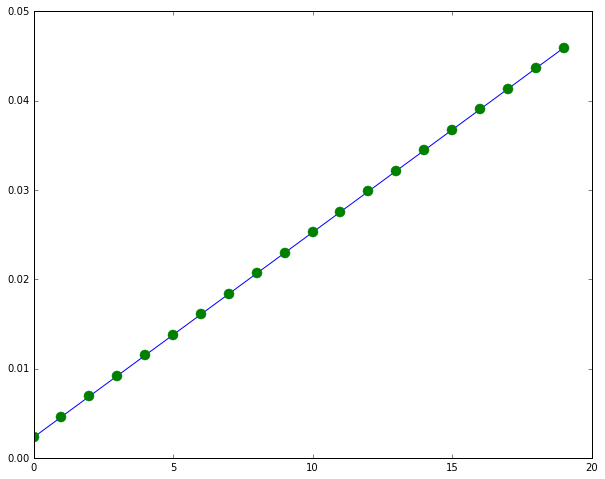

In [150]:
plt.plot(more_signal_freq[:20])
plt.plot(lower_freqs[:20], '.', markersize=20)

In [153]:
lower_amps = np.array([more_signal_amp[i] for i in range(len(more_signal_amp)) if more_signal_freq[i] <= np.max(lower_freqs)])
print(len(lower_amps))
print(len(lower_freqs))

174
174


In [154]:
cuminfo_ideal = info_at_freq(lower_freqs, lower_amps, ideal_filter_interp, output_noise=output_noise, input_noise=input_noise)
cuminfo_model = info_at_freq(lower_freqs, lower_amps, model_interp, function_const=model_const, output_noise=output_noise, input_noise=input_noise)
cuminfo_a = info_at_freq(lower_freqs, lower_amps, a_interp, function_const=a_const, output_noise=output_noise, input_noise=input_noise)
cuminfo_h = info_at_freq(lower_freqs, lower_amps, h_interp, function_const=h_const, output_noise=output_noise, input_noise=input_noise)

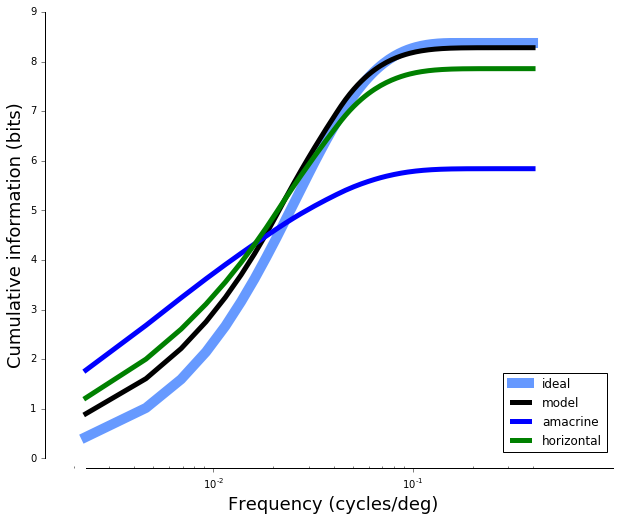

In [155]:
plt.plot(lower_freqs, np.cumsum(cuminfo_ideal), color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, np.cumsum(cuminfo_model), color='k', linewidth=5, label='model')
plt.plot(lower_freqs, np.cumsum(cuminfo_a), color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, np.cumsum(cuminfo_h), color='g', linewidth=5, label='horizontal')
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('Cumulative information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])

## How much information do ganglion cell RFs transmit?

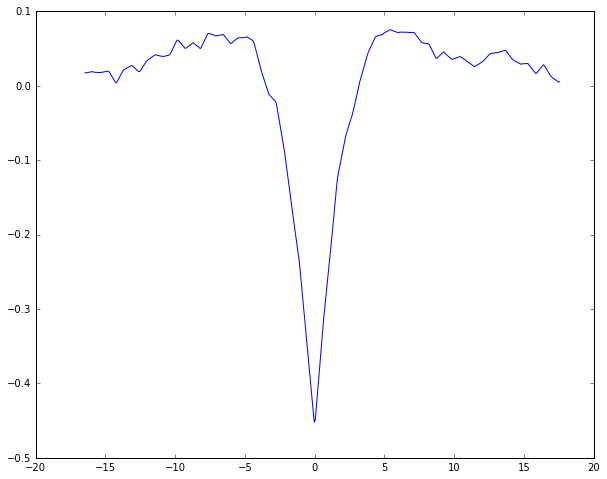

In [199]:
plt.plot(valid_space, mean_ganglion-np.mean(mean_ganglion))

In [202]:
rf_f_two_sided = abs(np.fft.fft(mean_ganglion-np.mean(mean_ganglion))) / np.prod(mean_ganglion.shape)
n = len(rf_f_two_sided)
if n % 2 == 0:
    rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
else:
    rf_f_one_sided = rf_f_two_sided[:(n-1)/2 + 1]
spacing = valid_space[-1] - valid_space[-2]
rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

ganglion_freqs = rf_freqs_one_sided
ganglion_amps = rf_f_one_sided

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1)

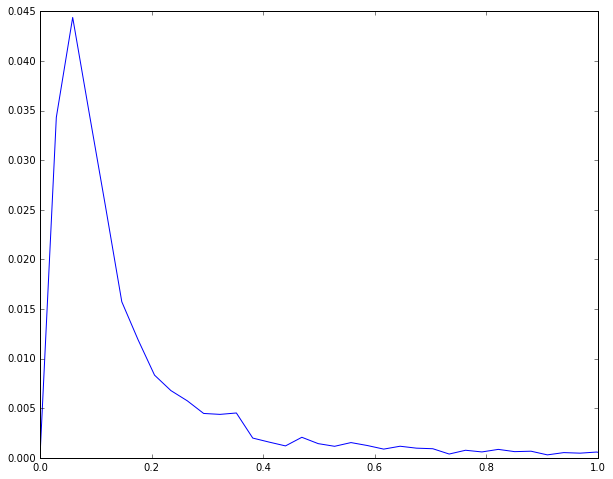

In [203]:
plt.plot(ganglion_freqs, ganglion_amps)
plt.xlim([0,1])

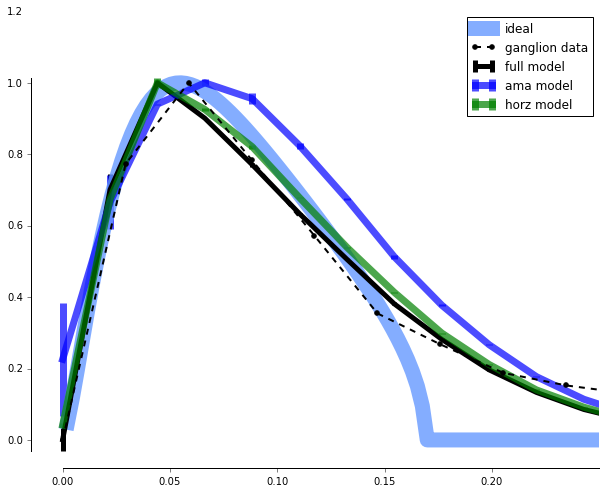

In [204]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='#6699ff', linewidth=15, alpha=0.8, label='ideal')
plt.errorbar(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), yerr=sem(both_ffts/np.nanmax(filt_expt_both)), 
             color='k', linewidth=5, alpha=1.0, capthick=5, capsize=0, label='full model')
plt.errorbar(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), yerr=sem(a_ffts/np.nanmax(filt_expt_a)),
            color='b', alpha=0.7, linewidth=7, capthick=5, capsize=0, label='ama model')
plt.errorbar(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), yerr=sem(h_ffts/np.nanmax(filt_expt_h)),
            color='g', alpha=0.7, linewidth=7, capthick=5, capsize=0, label='horz model')
plt.plot(ganglion_freqs, ganglion_amps/np.nanmax(ganglion_amps), 'k.--', markersize=10, linewidth=2, label='ganglion data')
# plt.plot(a_freqs, a_fft, 'b.', linewidth=2, markersize=20, label='ama only', alpha=0.5)
plt.xlim([-0.01,0.25])
plt.ylim([-0.05, 1.2])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.legend()
# plt.savefig('Fig4B-C_one_plot.pdf', fonttype=42)

In [205]:
ganglion_interp = interp1d(ganglion_freqs, ganglion_amps/np.nanmax(ganglion_amps), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

def constrain_ganglion_var(ganglion_const):
    output_variance = np.sum((signal_interp(lower_freqs)*ideal_filter_interp(lower_freqs))**2 +
                          (input_noise * ideal_filter_interp(lower_freqs))**2 +
                          (output_noise)**2)
    ganglion_variance = np.sum((signal_interp(lower_freqs)*ganglion_const*ganglion_interp(lower_freqs))**2 +
                          (input_noise * ganglion_const * ganglion_interp(lower_freqs))**2 +
                          (output_noise)**2)
    
    return (output_variance - ganglion_variance)**2

In [206]:
init_ganglion_const = 1.02

In [207]:
ganglion_const_opt = scipy.optimize.minimize(constrain_ganglion_var, init_ganglion_const)
ganglion_const = ganglion_const_opt['x']
ganglion_const_opt

      fun: 1.2693102168632288e-15
 hess_inv: array([[ 0.02226495]])
      jac: array([ -3.05797085e-09])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 1.04158004])

In [208]:
cuminfo_ganglion = info_at_freq(lower_freqs, lower_amps, ganglion_interp, function_const=ganglion_const, output_noise=output_noise, input_noise=input_noise)

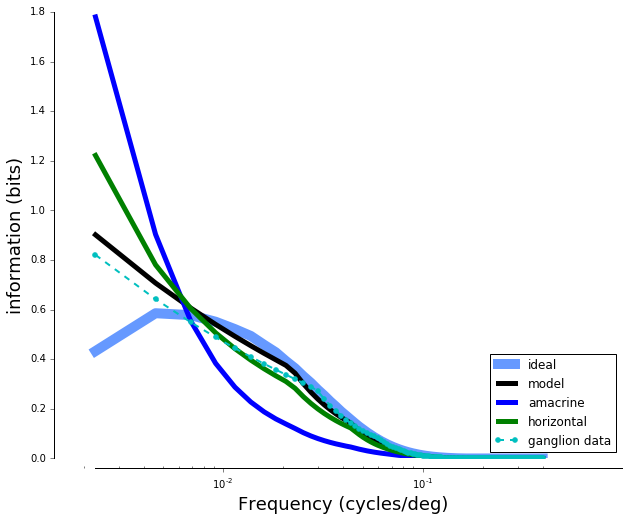

In [218]:
plt.plot(lower_freqs, cuminfo_ideal, color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, cuminfo_model, color='k', linewidth=5, label='model')
plt.plot(lower_freqs, cuminfo_a, color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, cuminfo_h, color='g', linewidth=5, label='horizontal')
plt.plot(lower_freqs, cuminfo_ganglion, 'c.--', linewidth=2, markersize=10, label='ganglion data')
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])

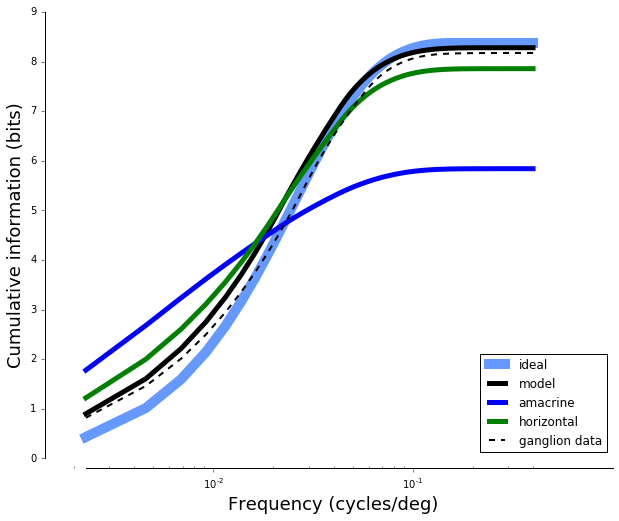

In [210]:
plt.plot(lower_freqs, np.cumsum(cuminfo_ideal), color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, np.cumsum(cuminfo_model), color='k', linewidth=5, label='model')
plt.plot(lower_freqs, np.cumsum(cuminfo_a), color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, np.cumsum(cuminfo_h), color='g', linewidth=5, label='horizontal')
plt.plot(lower_freqs, np.cumsum(cuminfo_ganglion), 'k--', linewidth=2, markersize=10, label='ganglion data')
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('Cumulative information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])

In [211]:
np.sum(cuminfo_ganglion)

8.1759197105080137

In [212]:
np.sum(cuminfo_ideal)

8.3767523543051325

In [213]:
np.sum(cuminfo_ganglion)/np.sum(cuminfo_ideal)

0.97602499927147746

In [214]:
np.sum(cuminfo_model)/np.sum(cuminfo_ideal)

0.9886566649402192

In [215]:
np.sum(cuminfo_h)/np.sum(cuminfo_ideal)

0.9382328350597724

In [216]:
np.sum(cuminfo_a)/np.sum(cuminfo_ideal)

0.6974540847264642

## Plot cumulative information including center

In [219]:
center = gaussian(x=valid_space, sigma=center_width, mu=0)
rf_f_two_sided = abs(np.fft.fft(center)) / np.prod(center.shape)
n = len(rf_f_two_sided)
if n % 2 == 0:
    rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
else:
    rf_f_one_sided = rf_f_two_sided[:(n-1)/2 + 1]
spacing = valid_space[-1] - valid_space[-2]
rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

center_freqs = rf_freqs_one_sided
center_amps = rf_f_one_sided

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1)

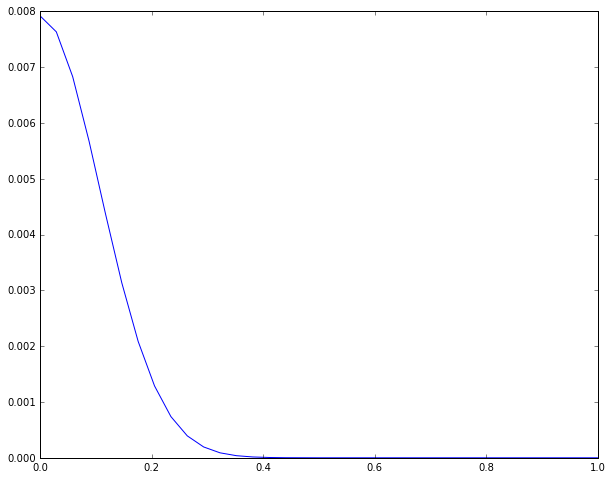

In [221]:
plt.plot(center_freqs, center_amps)
plt.xlim([0,1])

In [222]:
center_interp = interp1d(center_freqs, center_amps/np.nanmax(center_amps), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

def constrain_center_var(center_const):
    output_variance = np.sum((signal_interp(lower_freqs)*ideal_filter_interp(lower_freqs))**2 +
                          (input_noise * ideal_filter_interp(lower_freqs))**2 +
                          (output_noise)**2)
    center_variance = np.sum((signal_interp(lower_freqs)*center_const*center_interp(lower_freqs))**2 +
                          (input_noise * center_const * center_interp(lower_freqs))**2 +
                          (output_noise)**2)
    
    return (output_variance - center_variance)**2


In [224]:
init_center_const = 0.7
center_const_opt = scipy.optimize.minimize(constrain_center_var, init_center_const)
center_const = abs(center_const_opt['x'])
center_const_opt

      fun: 4.721804794647017e-14
 hess_inv: array([[ 0.00058901]])
      jac: array([ -1.36777697e-08])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([-0.16941066])

In [225]:
cuminfo_center = info_at_freq(lower_freqs, lower_amps, center_interp, function_const=center_const, output_noise=output_noise, input_noise=input_noise)

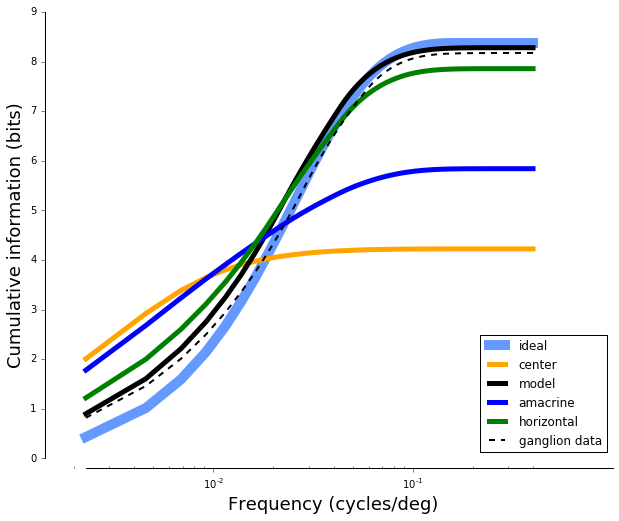

In [230]:
plt.plot(lower_freqs, np.cumsum(cuminfo_ideal), color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, np.cumsum(cuminfo_center), 'orange', linewidth=5, label='center')
plt.plot(lower_freqs, np.cumsum(cuminfo_model), color='k', linewidth=5, label='model')
plt.plot(lower_freqs, np.cumsum(cuminfo_a), color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, np.cumsum(cuminfo_h), color='g', linewidth=5, label='horizontal')
plt.plot(lower_freqs, np.cumsum(cuminfo_ganglion), 'k--', linewidth=2, markersize=10, label='ganglion data')

plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('Cumulative information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.savefig('Cumulative_info_plot.pdf', fonttype=42)

# Generate colormaps of information as fn of model params